In [461]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import seaborn as sns 


from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

label_size = 8
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
%matplotlib inline 

## Helper functions 

In [460]:
def weather_mean(df):
    inp_cols = ['TMPC', 'TMIN', 'PCPN', 'TMAX']
    out_cols = ['tavg', 'tmin', 'pcpn', 'tmax']
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    
    for i in range(4): 
        incol = inp_cols[i]
        outcol = out_cols[i]
        cols = [month+'_'+incol for month in months]
        df[outcol]= df[cols].mean(axis=1)
        
    return df 

def load_clim_proj(): 

    projectiondf = pd.read_csv('./data/climate_projections.csv').reset_index()
    projectiondf = weather_mean(projectiondf)
    clim_proj = projectiondf[['FIPS', 'tavg', 'tmax', 'tmin','pcpn', 'YEAR']]
    clim_proj.columns = ['FIPS', 'tavg', 'tmax', 'tmin','pcpn', 'year']
    clim_proj = clim_proj[(clim_proj['year'] <= 2025) & (clim_proj['year']>2017)]
    clim_proj['tavg'] = clim_proj['tavg'].apply(lambda x: 1.8*x + 32)
    clim_proj['tmin'] = clim_proj['tmin'].apply(lambda x: 1.8*x + 32)
    clim_proj['tmax'] = clim_proj['tmax'].apply(lambda x: 1.8*x + 32)
    clim_proj['FIPS'] = clim_proj['FIPS'].apply(lambda x: str(x).zfill(5))
    
    return clim_proj


def load_clim_proj_all(): 

    projectiondf = pd.read_csv('./data/processed/climate_projections_all.csv').reset_index()
    projectiondf = weather_mean(projectiondf)
    clim_proj_all = projectiondf[['FIPS', 'tavg', 'tmax', 'tmin','pcpn', 'YEAR']]
    clim_proj_all.columns = ['FIPS', 'tavg', 'tmax', 'tmin','pcpn', 'year']
    clim_proj_all = clim_proj_all[(clim_proj_all['year'] <= 2025) & (clim_proj_all['year']>=2000)]
    clim_proj_all['tavg'] = clim_proj_all['tavg'].apply(lambda x: 1.8*x + 32)
    clim_proj_all['tmin'] = clim_proj_all['tmin'].apply(lambda x: 1.8*x + 32)
    clim_proj_all['tmax'] = clim_proj_all['tmax'].apply(lambda x: 1.8*x + 32)
    clim_proj_all['FIPS'] = clim_proj_all['FIPS'].apply(lambda x: str(x).zfill(5))
    clim_proj_all = clim_proj_all.drop(clim_proj_all[(clim_proj_all.FIPS=='25019')].index) # dropping nantucket 
    return clim_proj_all


def create_test_train_data(df, lastyear):
    temp_test = df[df['ds'] > lastyear] 
    temp_train = df[df['ds'] <= lastyear]

    temp_train.ds = pd.to_datetime((temp_train.ds),format='%Y')
    temp_test.ds = pd.to_datetime((temp_test.ds),format='%Y')

    return temp_train, temp_test

def run_prophet(train, test): 

    m0 = Prophet(growth='linear', n_changepoints=1, changepoint_prior_scale=0.1, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    m0.add_regressor('tmin', prior_scale=0.1, mode='multiplicative')
    m0.add_regressor('tmax', prior_scale=0.1, mode='multiplicative')
    m0.add_regressor('tavg', prior_scale=0.1, mode='multiplicative')
    m0.add_regressor('pcpn', prior_scale=0.1, mode='multiplicative')
    m0.fit(train)

    fcst = m0.predict(test)
    return fcst, m0 

def clean_forecast(fcst):
    
    fcs = fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    fcs['year'] = pd.DatetimeIndex(fcs['ds']).year
    fcs = fcs[['year', 'yhat', 'yhat_lower', 'yhat_upper']]
    fcs.columns = ['year', 'Cases_new', 'Cases_lower', 'Cases_upper']
    return fcs 

In [418]:
# will do the prediction for all counties which have a number greater than 10 in 2010 - sufficiently long enough baseline

df = pd.read_csv('./data/processed/alldata.csv')
df['FIPS'] = df['FIPS'].apply(lambda x: str(x).zfill(5))

# remove the last two years from MA 

df.drop(df[(df.Stname=='Massachusetts') & (df.year>2015)].index)
list_val_counties = df[(df.Cases>10) & (df.YR==2010)].FIPS.unique()
val_df = df[df['FIPS'].isin(list_val_counties)]

imp_cols = ['FIPS', 'Ctyname', 'Stname', 'STCODE', 'CTYCODE', 'Cases', 'CENSUSAREA',
       'geometry', 'year', 'Forest & Woodland','Cases_new', 'long', 'lat', 'counties',
       'TOT_POP', 'POP_URBAN', 'POPPCT_URBAN',  'AREA_URBAN', 'AREAPCT_URBAN', 'POP_RURAL', 'POPPCT_RURAL',
       'AREA_RURAL', 'AREAPCT_RURAL', 'Cases_norm', 'tavg', 'tmax', 'tmin', 'pcpn']

stat_cols = ['FIPS', 'Ctyname', 'Stname', 'STCODE', 'CTYCODE', 'geometry', 'lat', 'Forest & Woodland','POPPCT_URBAN','POPPCT_RURAL', 
                'AREAPCT_URBAN','AREAPCT_RURAL']

val_df = val_df[imp_cols]
xval_df = df[~df['FIPS'].isin(list_val_counties)][imp_cols]

val_df = val_df.drop(val_df[(val_df.FIPS=='25019')].index) # dropping nantucket 
xval_df = xval_df.drop(xval_df[(xval_df.FIPS=='25019')].index) # dropping nantucket 

val_df.to_csv('./data/processed/fitting_df.csv')
## loading climate projections 
#clim_proj = load_clim_proj()

clim_proj_all = load_clim_proj_all()
clim_proj_all[clim_proj_all.isna().any(axis=1)]

In [430]:
weather = pd.read_csv('./data/interim/weather.csv')
weather = weather_mean(weather)[['YR', 'ST', 'DIV', 'tavg', 'pcpn', 'tmax', 'tmin']]
weather.columns = ['year', 'ST', 'DIV', 'tavg', 'pcpn', 'tmax', 'tmin']

weather['ST_new'] = weather.ST.apply(lambda x: str(x).zfill(2))
weather['CT_new'] = weather.DIV.apply(lambda x: str(x).zfill(3))
weather['FIPS'] = weather.ST_new + weather.CT_new

In [431]:
statdf = val_df[stat_cols].drop_duplicates()
xstatdf = xval_df[stat_cols].drop_duplicates()

fips_all = statdf['FIPS'].unique()
slopes = []

for i in range(len(fips_all)): 
    fip = fips_all[i]
    temp = val_df[val_df['FIPS']==fip]
    years = temp[['year']].values[4:-2]
    cases = temp[['Cases']].values[4:-2]
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_[0][0])
    
statdf['Slopes'] = slopes
xstatdf['Slopes'] = 0 

allstatdf = statdf.append(xstatdf)

allstatdf.to_csv('./data/processed/allstatdf.csv')

## County-by-county time series 


In [455]:
final_df_individual = val_df.copy()
allfips = val_df.FIPS.unique()
    
mostfips = fips_classes[0].append(fips_classes[-1])

climfips = list(clim_proj_all.FIPS.unique())

for fip in mostfips: 
    
    if fip in climfips: 

        val_i = val_df[val_df['FIPS']==fip][['Cases_new', 'year']]
        clim_i_all = clim_proj_all[clim_proj_all['FIPS']==fip][['year', 'tavg', 'tmax', 'tmin', 'pcpn']]
        val_i = val_i.drop(val_i[(val_i.year<2006)].index).merge(clim_i_all, how='outer')
        val_i.columns = ['y', 'ds', 'tavg', 'tmax', 'tmin', 'pcpn']

        lastyear = max(val_df[val_df['FIPS']==fip].year.unique())-2

        # create train, test set 

        train, test = create_test_train_data(val_i, lastyear)

        # run forecast 

        fcst, m0 = run_prophet(train, test)
        fcs = clean_forecast(fcst)

        val_i['Pred'] = 0 
        val_pred_i = val_i.merge(fcs, how='left', left_on='ds', right_on='year').drop('year', axis=1)
        val_pred_i.Cases_new.fillna(val_pred_i.y, inplace=True)
        val_pred_i.Cases_upper.fillna(0.0, inplace=True)
        val_pred_i.Cases_lower.fillna(0.0, inplace=True)
        val_pred_i['Pred'] = 0 
        mask = val_pred_i['ds']>=lastyear
        val_pred_i['Pred'][mask] = 2

        temp_row = val_df[val_df.FIPS==fip].iloc[0].copy()
        new_cols = val_pred_i[val_pred_i['ds'] >= lastyear].drop('y', axis=1).copy()

        tempdf = pd.DataFrame()

        for i in range(len(new_cols)):
            temp_row['Cases_new'] = new_cols['Cases_new'].iloc[i]
            temp_row['year'] = new_cols['ds'].iloc[i]
            temp_row['Cases_upper'] = new_cols['Cases_upper'].iloc[i]
            temp_row['Cases_lower'] = new_cols['Cases_lower'].iloc[i]
            temp_row['tavg'] = new_cols['tavg'].iloc[i]
            temp_row['tmax'] = new_cols['tmax'].iloc[i]
            temp_row['tmin'] = new_cols['tmin'].iloc[i]
            temp_row['pcpn'] = new_cols['pcpn'].iloc[i] 
            temp_row['Pred'] = new_cols['Pred'].iloc[i]
            tempdf = tempdf.append(temp_row)

        final_df_individual = final_df_individual.append(tempdf)

final_df_individual.to_csv('./data/processed/data_pred_indi.csv')

/Users/avani/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Use

## Clustering and EDA 

- why this form of clustering? What does the clustering mean? Here is where we should bring in hierarchical time series forecasting  
- To reduce the dimensionality, also add as features the number of months that its warm and wet,or that the average temp is > 45 degrees and its not dry i.e. precipipation is not 0. 



In [937]:
cluster_df = statdf.drop_duplicates()
X = np.array(cluster_df[['lat','Slopes','Forest & Woodland']])

for nclusters in range(1,10): 
    
    gmclusts = GaussianMixture(n_components=nclusters)
    gmclusts.fit(X)
    bic = gmclusts.bic(X)
    print(nclusters, bic)

1 3803.18977229
2 3539.61442411
3 3536.37121114
4 3504.14001458
5 3488.00907501
6 3481.83640621
7 3508.00833892
8 3598.25938036
9 3508.8153014


In [938]:
# 4 clusters is the winner! 

In [11]:
nclusters = 4

cluster_df = statdf.drop_duplicates()
X = np.array(cluster_df[['lat','Slopes','Forest & Woodland']])
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)
cluster_df['Label'] = y_kmeans

fips_classes = []

cases_2010 = val_df[val_df['year']==2010][['FIPS', 'Cases_new']]
cases_2010.columns = ['FIPS', 'Cases2010']
val_df_norms = val_df.merge(cases_2010, on='FIPS', how='left')
val_df_norms['Cases_norm_2010'] = val_df_norms['Cases_new']/val_df_norms['Cases2010']
val_df_norms.Label = 0 

for i in range(nclusters): 
    fips_classes.append(cluster_df[cluster_df['Label']==i]['FIPS'])
    mask = val_df_norms['FIPS'].isin(fips_classes[i])
    val_df_norms.loc[mask, 'Label'] = i


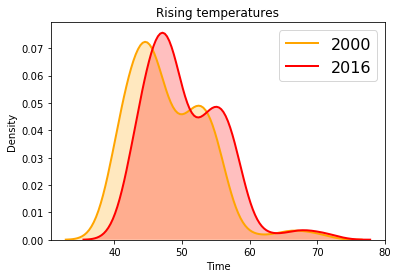

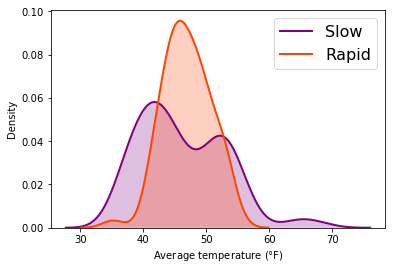

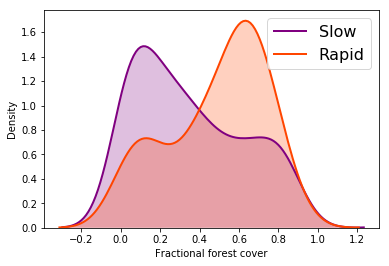

In [13]:
counties_class = val_df_norms[['FIPS', 'Label']].drop_duplicates()

counties_labels_all = val_df.set_index('FIPS').join(counties_class.set_index('FIPS')).reset_index()

xx = counties_labels_all[(counties_labels_all['Label']==0) & (counties_labels_all['year']==2000)]
yy = counties_labels_all[(counties_labels_all['Label']==0) & (counties_labels_all['year']==2016)]

plt.figure()
sns.distplot(xx.tavg.drop_duplicates(), hist=False, kde=True, color='orange', kde_kws = {'shade': True, 'linewidth': 2}, label='2000')
sns.distplot(yy.tavg.drop_duplicates(), hist=False, kde=True, color='red', kde_kws = {'shade': True, 'linewidth': 2}, label='2016')
plt.legend(prop={'size': 16})
plt.title('Rising temperatures')
plt.xlabel('Time')
plt.ylabel('Density')
plt.savefig('images/clim_change.jpeg', format='jpeg', dpi=200)

############ Tavg #################

xx = counties_labels_all[(counties_labels_all['Label']==0) & (counties_labels_all['year']==2014)]
yy = counties_labels_all[(counties_labels_all['Label']==3) & (counties_labels_all['year']==2014)]

plt.figure()
sns.distplot(xx.tavg.drop_duplicates(), hist=False, kde=True, color='purple', kde_kws = {'shade': True, 'linewidth': 2}, label='Slow')
sns.distplot(yy.tavg.drop_duplicates(), hist=False, kde=True, color='orangered', kde_kws = {'shade': True, 'linewidth': 2}, label='Rapid')
plt.legend(prop={'size': 16})
plt.xlabel('Average temperature ($\degree$F)')
plt.ylabel('Density')
plt.savefig('images/temp.jpeg', format='jpeg', dpi=200)

############ Forest_cover #################

xx = counties_labels_all[counties_labels_all['Label']==0]['Forest & Woodland'].drop_duplicates()
yy = counties_labels_all[counties_labels_all['Label']==3]['Forest & Woodland'].drop_duplicates()

plt.figure()
sns.distplot(xx, hist=False, kde=True, color='purple', kde_kws = {'shade': True, 'linewidth': 2}, label='Slow')
sns.distplot(yy, hist=False, kde=True, color='orangered', kde_kws = {'shade': True, 'linewidth': 2}, label='Rapid')
plt.legend(prop={'size': 16})
plt.xlabel('Fractional forest cover')
plt.ylabel('Density')
plt.savefig('images/forest.jpeg', format='jpeg', dpi=200)

In [14]:
class1 = counties_labels_all[counties_labels_all['Label']==1][['Cases', 'lat', 'tavg', 'tmin', 'tmax','pcpn']]
class3 = counties_labels_all[counties_labels_all['Label']==3][['Cases', 'lat', 'tavg', 'tmin', 'tmax','pcpn']]

class1.describe()

,Cases,lat,tavg,tmin,tmax,pcpn
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,256.120915,41.807059,49.662908,39.650545,59.667511,3.911424
std,219.508456,0.966474,2.140777,2.407868,2.042447,0.578219
min,0.000000,40.309000,44.183333,34.108333,54.283333,2.770833
25%,64.250000,40.911000,48.327083,38.087500,58.435417,3.483333
50%,208.000000,41.870000,49.833333,39.729167,59.854167,3.873750
75%,406.000000,42.484000,51.170833,41.258333,61.200000,4.252500
max,1023.000000,43.848000,54.891667,46.433333,64.566667,5.696667


In [15]:
class3.describe()

,Cases,lat,tavg,tmin,tmax,pcpn
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000
mean,122.564163,42.102676,48.687656,38.654734,58.715245,3.746886
std,133.168513,1.833215,3.738988,3.803709,3.783431,0.724426
min,0.000000,37.171000,35.208333,24.308333,46.100000,1.760833
25%,19.250000,40.864000,45.937500,36.033333,55.843750,3.288958
50%,86.500000,41.803000,48.416667,38.416667,58.479167,3.722917
75%,179.750000,43.307000,51.231250,41.229167,61.256250,4.170000
max,1088.000000,47.604000,58.316667,48.183333,68.441667,6.419167


## Time-series on the clustered data 

In [267]:
final_df = pd.DataFrame()

models = []
futures = []
datas = []

baseline_errs = []
model_errs = []

for i in range(nclusters): 

    val_i = val_df_norms[val_df_norms['Label']==i].groupby(['year'])['Cases_norm_2010'].mean().reset_index()
    clim_i_all = clim_proj_all[clim_proj_all['FIPS'].isin(fips_classes[i])].groupby('year')['tavg', 'tmax', 'tmin', 'pcpn'].mean().reset_index()

    val_i = val_i.drop(val_i[(val_i.year<2006)].index).merge(clim_i_all, how='outer')
    val_i.columns = ['ds', 'y', 'tavg', 'tmax', 'tmin','pcpn']

    train, test = create_test_train_data(val_i, 2015)
    fcst, m0 = run_prophet(train, test) 
    
    models.append(m0)
    datas.append(train)
    futures.append(test)

    fcs = clean_forecast(fcst)
        
    fcs.columns = ['year', 'Cases_norm', 'Cases_norm_lower', 'Cases_norm_upper']
    preds = np.array(fcs.loc[0:1].Cases_norm)
    baseline = train.iloc[-2].y

    baseline_err = abs(np.array(test.iloc[0:2].y) - baseline)/np.array(test.iloc[0:2].y)
    model_err = abs(np.array(test.iloc[0:2].y) - preds)/np.array(test.iloc[0:2].y)
    
    baseline_errs.append(baseline_err)
    model_errs.append(model_err)
    
    val_i['Pred'] = 0 

    val_pred_i = val_i.merge(fcs, how='left', left_on='ds', right_on='year').drop('year', axis=1)
    val_pred_i.Cases_norm.fillna(val_pred_i.y, inplace=True)
    val_pred_i.Cases_norm_upper.fillna(0.0, inplace=True)
    val_pred_i.Cases_norm_lower.fillna(0.0, inplace=True)
    val_pred_i['Pred'] = 0 
    mask = val_pred_i['ds']>=2018
    val_pred_i['Pred'][mask] = 1

    for fip in fips_classes[i]:

        temp_row = val_df_norms[val_df_norms.FIPS==fip].iloc[0].copy()

        new_cols = val_pred_i.copy()
        new_cols['Cases_new'] = new_cols['Cases_norm']*temp_row.Cases2010
        new_cols['Cases_norm_upper'] = new_cols['Cases_norm_upper']*temp_row.Cases2010
        new_cols['Cases_norm_lower'] = new_cols['Cases_norm_lower']*temp_row.Cases2010

        
        tempdf = pd.DataFrame()

        for i in range(len(new_cols)):
            temp_row['Cases_new'] = new_cols['Cases_new'].iloc[i]
            temp_row['year'] = new_cols['ds'].iloc[i]
            temp_row['Cases_upper'] = new_cols['Cases_norm_upper'].iloc[i]
            temp_row['Cases_lower'] = new_cols['Cases_norm_lower'].iloc[i]
            temp_row['tavg'] = new_cols['tavg'].iloc[i]
            temp_row['tmax'] = new_cols['tmax'].iloc[i]
            temp_row['tmin'] = new_cols['tmin'].iloc[i]
            temp_row['pcpn'] = new_cols['pcpn'].iloc[i] 
            temp_row['Pred'] = new_cols['Pred'].iloc[i]
            tempdf = tempdf.append(temp_row)
        
        final_df = final_df.append(tempdf)

/Users/avani/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Use

In [361]:
baseline_errs

[array([ 0.30827759,  0.38296931]),
 array([ 0.12470612,  0.14800951]),
 array([ 0.0014843 ,  0.24378572]),
 array([ 0.18718938,  0.26302498])]

In [283]:
model_errs

[array([ 0.05752116,  0.10802511]),
 array([ 0.26746945,  0.06598048]),
 array([ 0.22156055,  0.41436035]),
 array([ 0.00167071,  0.08524429])]

In [270]:
final_df.to_csv('./data/processed/data_preds.csv')

In [317]:
cols = ['CTYCODE', 'Cases_new', 'Ctyname', 'FIPS',  'Pred', 'STCODE', 'Stname', 'TOT_POP',
       'counties', 'geometry', 'lat', 'long', 'year', 'Cases_lower','Cases_upper']
t1 = val_df.drop(val_df[(val_df.year>=2006)].index)[['CTYCODE', 'Cases_new', 'Ctyname', 'FIPS',  'STCODE', 'Stname', 'TOT_POP',
       'counties', 'geometry', 'lat', 'long', 'year']]
t1['Pred']=0
t1['Cases_upper']=0
t1['Cases_lower']=0
t2 = final_df[cols][cols]
t1.append(t2).to_csv('data_preds.csv')

/Users/avani/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [272]:
final_df[val_df.columns].append(xval_df).to_csv('data_pred_all.csv')

## Plot the models and predictions 

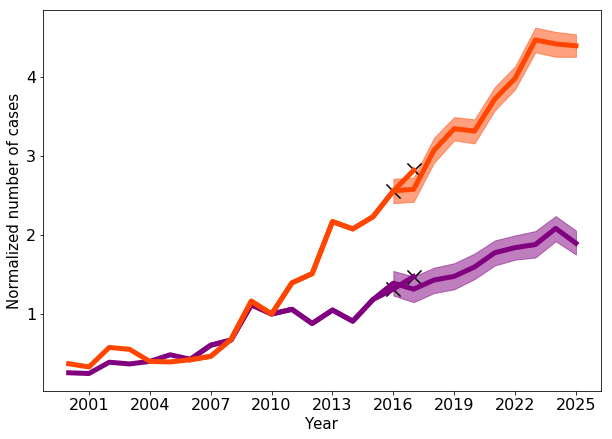

In [357]:
ax =  plt.figure(facecolor='w', figsize=(10,7)).gca()
colors = ['purple', 'red', 'red', 'orangered']

for i in [0,3]: 
    model = models[i]
    data = datas[i]
    test = futures[i]
    fcst = model.predict(test)
    
    total_years = data.ds.dt.year.append(fcst.ds.dt.year)
    total_data = data.y.append(fcst.yhat)
    
    val_i = val_df_norms[val_df_norms['Label']==i].groupby(['year'])['Cases_norm_2010'].mean().reset_index()

    ax.plot(val_i.year,val_i.Cases_norm_2010, colors[i], linewidth=5.0)
    ax.plot(total_years, total_data, colors[i], linewidth=5.0)
    ax.fill_between(fcst.ds.dt.year, fcst['yhat_lower'], fcst['yhat_upper'],
                color=colors[i], alpha=0.5)

    ax.scatter(test.ds.dt.year[0:2],test.y[0:2], color='black', marker='x', s=200)
    ax.set_ylabel('Normalized number of cases', size=15)
    ax.set_xlabel('Year', size=15)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
#ax.save('images/final.png', bbox_inches=extent.expanded(1.1, 1.2), dpi=200)


## Preparing data for HTS 

In [296]:
def classify_fips(fip, fips_classes): 
    for i in range(4):
        if fip in list(fips_classes[i]):
            return i+1
    return -1 

In [553]:
val_df_2['label'] = val_df_2['FIPS'].apply(lambda x : classify_fips(x, fips_classes)) 
val3 = val_df_2[['year','label', 'FIPS',  'Cases']]
val3.columns = ['Date', 'label' , 'FIPS', 'Cases']

val4 = val3[['Date', 'Cases']].groupby('Date').sum().reset_index()

for i in range(1,5):
    temp = val3[val3['label']==i][['Date', 'Cases']]
    temp = temp.groupby('Date').sum().reset_index()
    temp.columns = ['Date', 'label'+str(i)]
    val4 = val4.merge(temp)
    
for i in range(4):
    fips = fips_classes[i]
    for fip in list(fips):
        temp = val3[val3['FIPS']==fip][['Date', 'Cases']]
        temp = temp.groupby('Date').sum().reset_index()
        temp.columns = ['Date', str(fip)]
        val4 = val4.merge(temp)
        
        
val4.Date = pd.to_datetime((val4.Date),format='%Y')
val4.to_csv('val4.csv', index=False)